# 2-3. 特征基因选择

## 1. 背景

我们现在有了一个经过标准化的单细胞测序数据，其保留了细胞差异，同时消除了技术带来的采样误差。通常来说，我们经过上游的mapping（比对），我们会得到30,000到50,000个不等的基因。但是，我们只在第一步的质控中，删除了一小部分基因（少于20个细胞表达的基因）。但实际上，一个细胞表达的基因大约是3,000个左右。意味着我们的测序数据中的一大部分基因可能不具有与单细胞数据相关的生物学意义，这些基因大多数包含0计数，或者是在许多细胞中普遍出现的基因。

故在预处理环节，我们需要计算高可变基因（特征基因），排除那些不具有分析意义的基因，避免影响我们下游的建模以及生物学检测。

<img src="https://www.sc-best-practices.org/_images/feature_selection.jpeg" alt="Feature selection" class="bg-primary mb-1" width="800px">

在本章中，我们将介绍三种不同的特征基因选择：基于基因离散度，基于基因归一化方差以及基于基因的皮尔森残差。在传统的分析流程中，我们会采用基于基因离散度的方式去计算高可变基因，一般来说，我们首先确定了单细胞数据集中变异最大的一组基因。我们计算了所有单细胞中每个基因的平均值和离散度（方差/平均值），并根据基因的平均表达将其分为 20 个箱。然后，在每个箱内，我们对箱内所有基因的离散度进行z归一化，以识别表达值高度可变的基因。


## 2. 基于基因离散度

我们首先设置我们的环境。

In [15]:
import omicverse as ov
import scanpy as sc

ov.utils.ov_plot_set()

接下来，我们加载此前分析所用到的数据集，并进行移位对数标准化处理。

In [16]:
adata = sc.read(
    filename="s4d8_quality_control.h5ad",
    #backup_url="https://figshare.com/ndownloader/files/40014331",
)
#存储原始数据以便后续还原
ov.utils.store_layers(adata,layers='counts')
adata.layers['counts']=adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata

......The X of adata have been stored in counts
normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 14814 × 20171
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'layers_counts', 'log1p'
    layers: 'counts', 'soupX_counts'

接下来，我们调用`scanpy`包里的`pp.highly_variable_genes`函数来计算高可变基因，由于我们使用的是基于基因离散度的方法，故我们需要设置`flavor='seurat'`，该方法也是默认方法。基于基因离散度的方法寻找高变基因有两个途径：

- 指定目的高变基因数
- 指定离散度，平均值过滤高变基因

在这里，我们分别尝试两种不同的方法，首先是基于指定高变基因数的方法：

### 2.1 指定高可变基因数

由于是教程演示，所以我们不希望改变原来的anndata对象的`.var`，故我们设置`inplace=False`，旨在观察和对比高可变基因

In [3]:
adata_dis_num=sc.pp.highly_variable_genes(
    adata,
    flavor="seurat",
    n_top_genes=2000,
    subset=False,
    inplace=False,
)
adata_dis_num

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)


,means,dispersions,mean_bin,dispersions_norm,highly_variable
0,0.000955,0.001085,"(-0.00329, 0.186]",-1.267316,False
1,0.006057,0.715322,"(-0.00329, 0.186]",1.484390,True
2,0.036619,0.275313,"(-0.00329, 0.186]",-0.210809,False
3,0.022142,0.268974,"(-0.00329, 0.186]",-0.235233,False
4,0.002392,-0.093762,"(-0.00329, 0.186]",-1.632726,False
...,...,...,...,...,...
20166,0.003747,0.063567,"(-0.00329, 0.186]",-1.026594,False
20167,0.003144,0.307859,"(-0.00329, 0.186]",-0.085421,False
20168,0.062956,0.448886,"(-0.00329, 0.186]",0.457906,False
20169,0.012018,0.158723,"(-0.00329, 0.186]",-0.659990,False


In [4]:
adata_dis_num['highly_variable'].value_counts()

False    18171
True      2000
Name: highly_variable, dtype: int64

我们发现，一共选择了2000个高可变基因，这与我们最开始的分析目标一致，至于选择出来的高可变基因有什么用途，则留在下一章节讨论

### 2.2 指定基因离散度与平均值阈值

除了指定高可变基因数量外，我们还可以通过基因的离散度与平均值的阈值，去计算高可变基因，但是，这种启发式的方法是数据敏感的，阈值所计算出来的高可变基因可能并不是全部高可变。故基于阈值的方法在现在的分析中应用较少。

In [5]:
adata_dis_cutoff=sc.pp.highly_variable_genes(
    adata,
    flavor="seurat",
    min_disp=0.5,
    min_mean=0.0125,
    max_mean=3,
    subset=False,
    inplace=False,
)
adata_dis_cutoff['highly_variable'].value_counts()

extracting highly variable genes
    finished (0:00:00)


False    17291
True      2880
Name: highly_variable, dtype: int64

通过简单的计算我们发现，一共有2,880个高可变基因被选择了出来，一般2000-3000内的高可变基因数都是能接受的

因为非高可变基因在下游分析时会被过滤掉，我们会将归一化值给保存进raw文件，但这有个缺陷，我们将会永远失去非高可变基因的原始count。因此可以使用释放函数 `ov.utils.retrieve_layers`，与存放在adata.layers中的数据不同，`retrieve_layers`函数还可还原全基因的原始计数，我们以下将进行一个简单的对比实验。

In [12]:
#计算高可变基因（覆盖，inplace=True）
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat",
)
#只保留高可变基因
adata = adata[:, adata.var.highly_variable]
print('shape: ',adata.shape)

adata_counts=adata.copy()
ov.utils.retrieve_layers(adata_counts,layers='counts')
print('normalize adata:',adata.X.max())
print('raw count adata:',adata_counts.X.max())
print('shape: ',adata_counts.shape)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
shape:  (14814, 2880)
......The X of adata have been stored in raw
......The layers counts of adata have been retreved
normalize adata: 4.9448869840604806
raw count adata: 694.0
shape:  (14814, 2880)


In [13]:
#释放所有基因
adata_counts=adata.raw.to_adata().copy()
ov.utils.retrieve_layers(adata_counts,layers='counts')
print('normalize adata:',adata.X.max())
print('raw count adata:',adata_counts.X.max())
print('shape: ',adata_counts.shape)

......The X of adata have been stored in raw
......The layers counts of adata have been retreved
normalize adata: 4.9448869840604806
raw count adata: 889.0
shape:  (14814, 20171)


可以发现，我们使用.raw还原基因名后，`retrieve_layers`即可自动提取.raw中所包含的counts值。即数据的形状为 (14814, 20171)


## 3. 基于基因归一化方差

在过去的单细胞研究中人们发现，仅根据对数归一化法，并使用离散度的高可变基因选择方法无法解释单细胞 RNA-seq 固有的均值-方差关系。故在`seurat v3`中，研究人员使用了方差稳定变换来纠正这一点误差。这意味着我们将不使用标准化后的数据来计算高可变基因。该方法的计算步骤如下：

我们首先计算每一个基因的平均值 $\overline{x_i}$ 与方差 $\sigma_i$，然后分别对平均值与方差进行log对数化。然后我们使用2次多项式，将方差作为均值的函数，进行局部多项式回归。

$$ \sigma (x) = a x^2 +b x +c$$

通过上述公式，我们可以获得每一个基因的预期方差，然后我们进行z转换：

$$ z_{ij}= \frac {x_{ij}-\overline{x_i}} {\sigma (x_i)} $$

其中 $z_{ij}$ 是细胞j中基因i的标准化值，$x_{ij}$ 是细胞j中基因i的原始值，$\overline{x_i}$ 是基因i的平均原始值，并且 $\sigma (x_i)$ 是从全局均值方差拟合得出的特征i的预期标准差。为了减少技术异常值的影响，我们将标准化值削减为最大值 $\sqrt {N}$，其中N是细胞总数。然后，对于每个基因，我们计算所有细胞标准化值的方差。该方差表示控制均值表达后单细胞离散度的度量，我们直接使用它对特征进行排序。

在`scanpy`中，我们需要设定`flavor="seurat_v3"`以选择基于基因归一化方差的方法，并指定计数矩阵为未归一化的矩阵，即`layer='counts'`，同时我们选择标准化方差最高的 2,000 个基因作为“高度可变”。

In [9]:
adata_var_num=sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    layer='counts',
    n_top_genes=2000,
    subset=False,
    inplace=False,
)
adata_var_num['highly_variable'].value_counts()

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


False    18171
True      2000
Name: highly_variable, dtype: int64

## 4. 基于基因皮尔森近似残差

除了基于基因归一化残差以及离散度的方法外，我们还可以基于皮尔森近似残差的思想来计算高可变基因，你一定注意到了我们此前的归一化步骤中包含了皮尔森残差的方法，但是在这里，我们依然是使用原始计数来计算高可变基因，这是`scanpy`的实现原理所导致的，即我们可以使用移位对数来获得标准化数据，同时使用皮尔森残差法来获得高可变基因

针对没有生物学变异的UMI或计数数据的常见建模假设是，每个基因$g$在细胞$c$中占据了总计数$n_c$的一定比例$p_g$ [4, 6-10]。然后，观察到的UMI计数$X_{c g}$被建模为泊松分布或负二项分布（NB），其期望值为$\mu_{c g}=p_g n_c$，不考虑零膨胀：

$$
\begin{array}{r}
X_{c g} \sim \text { Poisson }\left(\mu_{c g}\right) \text { or } \mathrm{NB}\left(\mu_{c g}, \theta\right), \\
\mu_{c g}=n_c p_g .
\end{array}
$$

泊松模型有一个最大似然解，可以写成闭式形式：$\hat{n}_c=\sum_g X_{c g}$（测序深度），$\hat{p}_g=\sum_c X_{c g} / \sum_c \hat{n}_c$，或者合并在一起：

$$
\hat{\mu}_{c g}=\frac{\sum_j X_{c j} \cdot \sum_i X_{i g}}{\sum_{i j} X_{i j}}
$$

对于负二项模型，这个解仅适用于近似情况。利用这个解，皮尔森近似残差可表示为：

$$
Z_{c g}=\frac{X_{c g}-\hat{\mu}_{c g}}{\sqrt{\hat{\mu}_{c g}+\hat{\mu}_{c g}^2 / \theta}},
$$

其中$\mu_{c g}+\mu_{c g}^2 / \theta$是NB的方差，$\theta \rightarrow \infty$时得到泊松极限。皮尔森近似残差的方差，除了一个常数外，等于皮尔森$\chi^2$拟合优度统计量，用来量化每个基因与这个常量表达模型的偏差程度。正如Aedin Culhane指出的那样，在泊松模型下对皮尔森近似残差进行奇异值分解被称为对应分析，这是一种历史悠久的方法。

Hafemeister和Satija建议在高变异基因（HVG）筛选中使用来自相关NB回归模型的皮尔森近似残差，也可作为下游处理的数据转换方法。与此同时，Townes等人建议使用来自上述泊松模型的偏差残差进行HVG筛选

在`scanpy`中，我们将使用`experimental.pp.highly_variable_genes`来计算基于皮尔森残差的高可变基因

In [10]:
adata_pearson_num=sc.experimental.pp.highly_variable_genes(
    adata, 
    flavor="pearson_residuals",
    layer='counts',
    n_top_genes=2000,
    subset=False,
    inplace=False,
)
adata_pearson_num['highly_variable'].value_counts()

extracting highly variable genes


False    18171
True      2000
Name: highly_variable, dtype: int64

In [22]:
adata_dis_num

,means,dispersions,mean_bin,dispersions_norm,highly_variable
AL627309.1,0.000955,0.001085,"(-0.00329, 0.186]",-1.267316,False
AL627309.5,0.006057,0.715322,"(-0.00329, 0.186]",1.484390,True
LINC01409,0.036619,0.275313,"(-0.00329, 0.186]",-0.210809,False
LINC01128,0.022142,0.268974,"(-0.00329, 0.186]",-0.235233,False
LINC00115,0.002392,-0.093762,"(-0.00329, 0.186]",-1.632726,False
...,...,...,...,...,...
AC011043.1,0.003747,0.063567,"(-0.00329, 0.186]",-1.026594,False
AL354822.1,0.003144,0.307859,"(-0.00329, 0.186]",-0.085421,False
AL592183.1,0.062956,0.448886,"(-0.00329, 0.186]",0.457906,False
AC240274.1,0.012018,0.158723,"(-0.00329, 0.186]",-0.659990,False


现在，我们已经获得了3种不同的特征基因选择方法所得到的高可变基因，我们可以对比一下基因之间的重叠率，至于功能的研究则不在本章的考虑范围内。我们先将基因名赋予此前的结果

In [11]:
adata_dis_num.index=adata.var_names.copy()
adata_dis_cutoff.index=adata.var_names.copy()
adata_var_num.index=adata.var_names.copy()
adata_pearson_num.index=adata.var_names.copy()

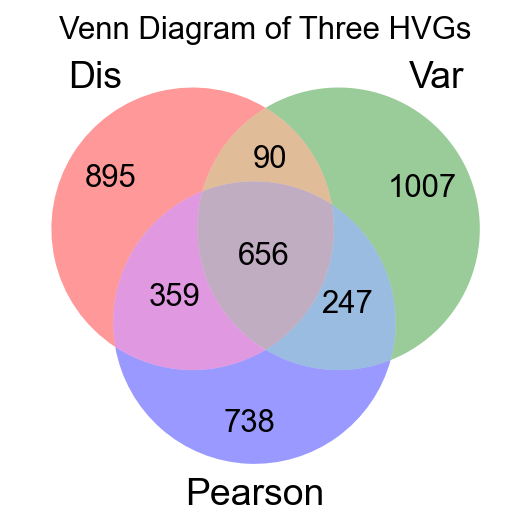

In [14]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# 三个列表的元素
list1 = set(adata_dis_num.loc[adata_dis_num['highly_variable']==True].index.tolist())
list2 = set(adata_var_num.loc[adata_var_num['highly_variable']==True].index.tolist())
list3 = set(adata_pearson_num.loc[adata_pearson_num['highly_variable']==True].index.tolist())

# 绘制 Venn 图
venn = venn3([list1, list2, list3], set_labels=('Dis', 'Var', 'Pearson'))


# 显示图形
plt.title("Venn Diagram of Three HVGs")
plt.show()


有意思的事情出现了，我们发现三种不同方法所找到的高可变基因（HVGs）仅有656个是相同的，这意味着不同的方法所寻找到的高可变基因可能会影响你的下游分析的误差。在我们的分析中，我们推荐使用皮尔森残差法来获得高可变基因。

在`omicverse`中，我们可以直接使用`ov.pp.preprocess`完成预处理步骤，需要注意的是，当`omicverse`的版本小于`1.4.13`时，mode的参数只能设置为`scanpy`或`pearson`，而在更高的版本中，normalize|HVGs：我们使用 | 来控制预处理步骤，| 前用于归一化步骤，可以是 `shiftlog` 或 `pearson`，| 后用于高度可变基因计算步骤，可以是 `pearson` 或 `seurat`。我们的默认值是 `shiftlog|pearson`。

In [17]:
adata = sc.read(
    filename="s4d8_quality_control.h5ad",
    #backup_url="https://figshare.com/ndownloader/files/40014331",
)
#存储原始数据以便后续还原
ov.utils.store_layers(adata,layers='counts')
adata.layers['counts']=adata.X.copy()

adata=ov.pp.preprocess(adata,
                       mode='shiftlog|pearson',
                       n_HVGs=2000,)
adata

......The X of adata have been stored in counts
Begin robust gene identification
After filtration, 20171/20171 genes are kept. Among 20171 genes, 20171 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


AnnData object with n_obs × n_vars = 14814 × 20171
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'layers_counts', 'log1p', 'hvg'
    layers: 'counts', 'soupX_counts'

注意，与`scanpy`不同，`omicverse`计算高可变基因后，将保存为`var['highly_variable_features']`，而在`scanpy`中，高可变将保存为`var['highly_variable']`

In [18]:
adata.var.head()

,gene_ids,feature_types,genome,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,percent_cells,robust,mean,var,residual_variances,highly_variable_rank,highly_variable_features
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,False,30,0.001831,0.001829,99.822842,31.0,3.465736,27,0.182260,True,0.001823,0.001819,0.783158,NaN,False
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,False,False,False,146,0.008976,0.008936,99.137829,152.0,5.030438,132,0.891049,True,0.008775,0.009239,1.063730,NaN,False
LINC01409,ENSG00000237491,Gene Expression,GRCh38,False,False,False,883,0.063009,0.061104,94.785638,1067.0,6.973543,820,5.535304,True,0.061158,0.082670,1.080966,NaN,False
LINC01128,ENSG00000228794,Gene Expression,GRCh38,False,False,False,533,0.036140,0.035503,96.852486,612.0,6.418365,464,3.132172,True,0.033617,0.042615,1.162746,NaN,False
LINC00115,ENSG00000225880,Gene Expression,GRCh38,False,False,False,72,0.004370,0.004360,99.574820,74.0,4.317488,66,0.445525,True,0.004388,0.004504,0.834976,NaN,False


In [19]:
adata.write_h5ad('s4d8_preprocess.h5ad')